In [1]:
import os
import torch
import time
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import random
import torch.nn as nn
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torch.autograd import Variable
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
from torch.utils.tensorboard import SummaryWriter  

In [2]:
np.random.seed(2020)
torch.manual_seed(2020)

### Set all paths according to your folder structure

In [3]:
# path to chexpert dataset with structure outlined in the project description
data_path = '/data'

train_csv_path = data_path + '/chexpert/v1.0/train.csv'
valid_csv_path = data_path + '/chexpert/v1.0/valid.csv'
dir_path = data_path + '/chexpert/v1.0/'

#path to the directory with saved state dictionaries
model_path = '/saves'

# Data preparation

In [4]:
# data pre-processing, combining training set and test set, only use frontal images.
train_csv = pd.read_csv(train_csv_path, sep=',').fillna(0)
valid_csv = pd.read_csv(valid_csv_path, sep=',').fillna(0)
train_csv = train_csv[~train_csv[train_csv.columns[3]].str.contains("Lateral")]
valid_csv = valid_csv[~valid_csv[valid_csv.columns[3]].str.contains("Lateral")]

#this image is lost
pa = 'CheXpert-v1.0/train/patient40761/study1/view1_frontal.jpg'
train_csv = train_csv[~train_csv[train_csv.columns[0]].str.contains(pa)]

# drop other information 
train_csv = train_csv.drop(['Sex', 'Age', 'Frontal/Lateral', 'AP/PA'], axis=1)
valid_csv = valid_csv.drop(['Sex', 'Age', 'Frontal/Lateral', 'AP/PA'], axis=1)

# Transforms

In [5]:
# transform data
normTransform = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomRotation(7),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    normTransform
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Dataset and dataloader

In [6]:
class Datasets(Dataset):
    
    def __init__(self, state, transform=None):
        self.path = state.iloc[1:,0].values
        labels = state.iloc[1:, 1:].values
        for row in range(labels.shape[0]):
            for column in range(labels.shape[1]):
                if labels[row][column] != 0.0 and labels[row][column] != 1.0:
                    labels[row][column] = round(np.random.uniform(0.55, 0.85), 2)
        self.labels = labels
        
        self.transform = transform
        
    def __getitem__(self, index):
        img_path = self.path[index]
        img_path = img_path.replace('CheXpert-', 'chexpert/')
        image = Image.open(os.path.join(data_path, img_path)).convert('RGB')
        label = self.labels[index]
        
        if self.transform:
            image = self.transform(image)
            
        return image, torch.FloatTensor(label)
            
    def __len__(self):
        return self.path.shape[0]

In [7]:
train_data = Datasets(train_csv, train_transform)
val_data = Datasets(valid_csv, test_transform)

# put it into dataloader
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

# Model

In [8]:
class DenseNet121(nn.Module):
    def __init__(self, num_classes, is_trained=True):

        super().__init__()
        
        # Load the DenseNet121 from ImageNet
        self.net = torchvision.models.densenet121(pretrained=is_trained)
        
        # Get the input dimension of last layer
        kernel_count = self.net.classifier.in_features
        
        # Replace last layer with new layer that have num_classes nodes, after that apply Sigmoid to the output
        self.net.classifier = nn.Sequential(nn.Linear(kernel_count, 500), nn.Dropout(p=0.9), nn.Linear(500, num_classes), nn.Sigmoid())
        
    def forward(self, inputs):
        
        return self.net(inputs)

In [ ]:
model = DenseNet121(14).cuda()


# Loss function and optimizer

In [ ]:
loss = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999))
learning_rate_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5, last_epoch=-1)

In [10]:
labels_name = train_csv.columns[1:].values
labels_name

array(['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
       'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation',
       'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion',
       'Pleural Other', 'Fracture', 'Support Devices'], dtype=object)

Pick only 5 diseases of interest

In [11]:
target = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']
target_index = [list(labels_name).index(item) for item in target]
target_index

[8, 2, 6, 5, 10]

In [12]:
labels_name[target_index]

array(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Pleural Effusion'], dtype=object)

# Training and evaluation

In [ ]:
target_scores = []
target_score_averages = []
new_scores = []

# use tensorboard to record
writer = SummaryWriter()

num_epoch = 40
best_score = 0.0
for epoch in range(num_epoch):
    epoch_star = time.time()
    train_loss = 0.0
    val_loss = 0.0
    val_pred = torch.FloatTensor().cuda()     # Tensor stores prediction values
    val_label = torch.FloatTensor().cuda()       # Tensor stores true values
    
    model.train()
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        train_prd = model(data[0].cuda())
        batch_loss = loss(train_prd, data[1].cuda())
        batch_loss.backward()
        optimizer.step()

        # tensorboard for batch loss
        train_loss += batch_loss.item()
        index_train = len(train_loader) * epoch + i
        writer.add_scalar('batch_loss', batch_loss.item() , index_train)
    
    model.eval()
    with torch.no_grad():
        for j,data in enumerate(val_loader):
            prd = model(data[0].cuda())
            batch_loss = loss(prd, data[1].cuda())

            val_loss += batch_loss.item()
            val_pred = torch.cat((val_pred, prd), 0)
            val_label = torch.cat((val_label, data[1].cuda()), 0)
      
    learning_rate_scheduler.step()
    
    #tensorboard for score and train loss
    target_score = [roc_auc_score(val_label.cpu().numpy()[:, i], val_pred.detach().cpu().numpy()[:, i],average='macro', multi_class='ovo') for i in target_index]
    target_scores.append(target_score)
    target_score_average = roc_auc_score(val_label.cpu().numpy()[:, target_index], val_pred.detach().cpu().numpy()[:, target_index],average='macro', multi_class='ovo')
    target_score_averages.append(target_score_average)
    
    train_loss = train_loss/len(train_loader)

    best_score = target_score_average.round(5)
    torch.save({'state_dict': model.state_dict(), 'optimizer' : optimizer.state_dict()}, os.path.join(model_path, f'epoch_{epoch}_score_{best_score}.pth'))
        
    writer.add_scalars('train/val for epochs', {'train_loss':np.array(train_loss), \
                                               'val_target':np.array(target_score_average),\
                                               'val_loss': np.array(val_loss)}, epoch)


writer.close()

### Compute ROC AUC score for each epoch of training

Go to the directory with saved state dictionaries and compute score for each file

In [21]:
target_scores = []
target_score_averages = []
valid_loss = []
file_list = sorted(os.listdir(model_path))[1:]

for name in file_list:
    model.load_state_dict(torch.load(os.path.join(model_path,name,))['state_dict'])

    val_pred = torch.FloatTensor().cuda()     # Tensor stores prediction values
    val_label = torch.FloatTensor().cuda()       # Tensor stores true values

    val_loss = 0.0
    with torch.no_grad():
        for j,data in enumerate(val_loader):
            prd = model(data[0].cuda())
            batch_loss = loss(prd, data[1].cuda())

            val_loss += batch_loss.item()
            val_pred = torch.cat((val_pred, prd), 0)
            val_label = torch.cat((val_label, data[1].cuda()), 0)
  



    target_score= [roc_auc_score(val_label.cpu().numpy()[:, i], val_pred.detach().cpu().numpy()[:, i],average='macro', multi_class='ovo') for i in target_index]
    target_score_average = roc_auc_score(val_label.cpu().numpy()[:, target_index], val_pred.detach().cpu().numpy()[:, target_index],average='macro', multi_class='ovo')
    target_score_averages.append(target_score_average)
    val = val_loss/len(val_loader)
    valid_loss.append(val)

In [22]:
file_list

['epoch_0_score_0.81219.pth',
 'epoch_1_score_0.81942.pth',
 'epoch_2_score_0.8163.pth',
 'epoch_3_score_0.83503.pth',
 'epoch_4_score_0.83824.pth',
 'epoch_5_score_0.83316.pth',
 'epoch_6_score_0.83204.pth',
 'epoch_7_score_0.83888.pth']

Text(0, 0.5, 'validation loss')

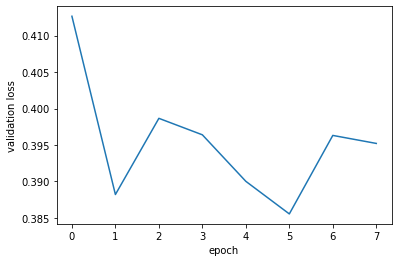

In [24]:
plt.plot(np.arange(8), valid_loss)
plt.xlabel('epoch')
plt.ylabel('validation loss')

Text(0, 0.5, 'auc_score')

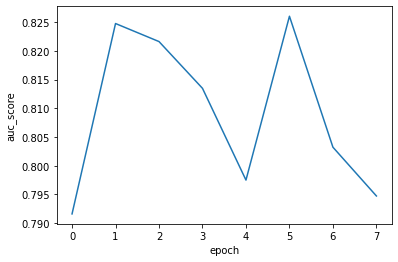

In [25]:
plt.plot(np.arange(8), target_score_averages)
plt.xlabel('epoch')
plt.ylabel('auc_score')

In [26]:
target_score_averages

[0.791594901950029,
 0.8247622573037722,
 0.8216202118696774,
 0.8134718962274781,
 0.7974899839056204,
 0.8260316592004138,
 0.8032170357608029,
 0.7947209223935723]